In [1]:
from typing import Dict

import pandas as pd
import seaborn as sns
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e5ljxu7z because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
df_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("../data/olist_orders_dataset.csv")
df_order_items = pd.read_csv("../data/olist_order_items_dataset.csv")

In [4]:
df_orders_reviews = pd.merge(df_orders, df_reviews, on='order_id')
df_orders_reviews_order_items = pd.merge(
    df_orders_reviews,
    df_order_items, on='order_id',
)

In [5]:
df = df_orders_reviews_order_items[['order_id', 'review_id', 'review_score', 'product_id']]

In [6]:
score_by_product_id: Dict[str, Dict[str, float]] = {}
for (order_id, review_id, review_score), order_rows in df.groupby(['order_id', 'review_id', 'review_score']):
    for product_id in {row[3] for row in order_rows.values}:
        if product_id not in score_by_product_id:
            score_by_product_id[product_id] = {'coef': 0, 'score': 0}
        coef = np.count_nonzero(order_rows.values[:, 3] == product_id) / order_rows.shape[0]
        score_by_product_id[product_id]['coef'] += coef
        score_by_product_id[product_id]['score'] += coef * review_score

In [7]:
product_ids = []
product_scores = []
for product_id, score_data in score_by_product_id.items():
    score = score_data['score'] / score_data['coef']
    score_by_product_id[product_id]['score_final'] = score
    product_ids.append(product_id)
    product_scores.append(score)

In [9]:
scores = pd.DataFrame({'product_id': product_ids, 'scores': product_scores})
scores.to_csv('../data/olist_product_scores.csv', index=False)

<AxesSubplot:xlabel='Count', ylabel='scores'>

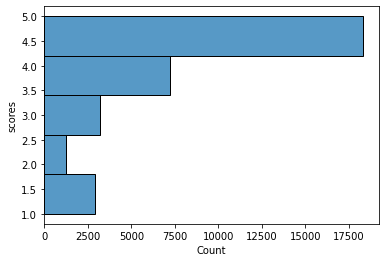

In [10]:
sns.histplot(data=scores, y='scores', bins=5)#.get_figure().savefig('data/oslint_product_scores_histplot')